# Variational Autoencoder
### Example on the MNIST Dataset

### Setup

In [ ]:
# imports
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# download MNIST dataset
train_data = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print('Data Successfully Loaded!')

Data Successfully Loaded!


In [ ]:
# hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 10

HIDDEN_LAYER_SIZE = 128
LATENT_DIMS = 2


**Architecture of Encoder Network**
 - *Input:* Tensor of shape (BATCH_SIZE, 1, 28, 28)
 - *Layer 1:* Convolutional layer
   - 1-channel $\to$ 16-channel
   - 3x3 kernal, stride=2, zero padding
   - ReLu activations
   - Learnable params = 16x1x3x3 + 16 = **160**
   - Output: Tensor of shape (BATCH_SIZE, 16, 14, 14)
 - *Layer 2:* Convolutional layer
   - 16-channel $\to$ 32-channel
   - 3x3 kernal, stride=2, zero padding
   - ReLu activations
   - Learnable params = 32x16x3x3 + 32 = **4,640**
   - Output: Tensor of shape (BATCH_SIZE, 32, 7, 7)
 - *Layer 3:* Linear layer
   - Flatten from (BATCH_SIZE, 32, 7, 7) $\to$ (BATCH_SIZE, 32x7x7)
   - HIDDEN_LAYER_SIZE neurons
   - ReLu activations
   - Learnable params = HIDDEN_LAYER_SIZEx(32x7x7) + HIDDEN_LAYER_SIZE = **1,569xHIDDEN_LAYER_SIZE**
   - Output: Tensor of shape (BATCH_SIZE, HIDDEN_LAYER_SIZE)
 - *Output:* Two heads, linear layers
   - *Head 1:* Mean of gaussian
      - LATENT_DIMS neurons
      - Linear activations
      - Learnable params = LATENT_DIMxHIDDEN_LAYER_SIZE + LATENT_DIMS = **(HIDDEN_LAYER_SIZE + 1)xLATENT_DIM**
      - Output: Tensor of shape (BATCH_SIZE, LATENT_DIMS)
   - *Head 2:* Log-variance of gaussian
      - LATENT_DIMS neurons
      - Linear activations
      - Learnable params = LATENT_DIMxHIDDEN_LAYER_SIZE + LATENT_DIMS = **(HIDDEN_LAYER_SIZE + 1)xLATENT_DIM**
      - Output: Tensor of shape (BATCH_SIZE, LATENT_DIMS)

**Architecture of Decoder Network**
 - *Input:* Tensor of shape (BATCH_SIZE, LATENT_DIMS)
 - *Layer 1:* Linear layer
   - HIDDEN_LAYER_SIZE neurons
   - ReLu activations
   - Learnable params = HIDDEN_LAYER_SIZExLATENT_DIMS + HIDDEN_LAYER_SIZE = **(LATENT_DIMS + 1)xHIDDEN_LAYER_SIZE**
   - Output: Tensor of shape (BATCH_SIZE, HIDDEN_LAYER_SIZE)
 - *Layer 2:* Linear layer
   - 32x7x7 neurons
   - ReLu activations
   - Learnable params = (32x7x7)xHIDDEN_LAYER_SIZE + (32x7x7) = **(32x7x7)x(HIDDEN_LAYER_SIZE + 1)**
   - Output: Tensor of shape (BATCH_SIZE, 32x7x7)
 - *Layer 3:* Transposed Convolutional layer
   - Reshape from (BATCH_SIZE, 32x7x7) $\to$ (BATCH_SIZE, 32, 7, 7)
   - 32-channel $\to$ 16-channel
   - 3x3 kernal, stride=2, zero padding
   - ReLu activations
   - Learnable params = 16x32x3x3 + 16 = **4,624**
   - Output: Tensor of shape (BATCH_SIZE, 16, 14, 14)
 - *Output:* Transposed Convolutional layer
   - 16-channel $\to$ 1-channel
   - 3x3 kernal, stride=2, zero padding
   - Sigmoid activations
   - Learnable params = 16x1x3x3 + 1 = **145**
   - Output: Tensor of shape (BATCH_SIZE, 1, 28, 28)

In [ ]:
# define models
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=32*7*7, out_features=HIDDEN_LAYER_SIZE),
            nn.ReLU()
        )
        self.output1 = nn.Linear(in_features=HIDDEN_LAYER_SIZE, out_features=LATENT_DIMS)
        self.output2 = nn.Linear(in_features=HIDDEN_LAYER_SIZE, out_features=LATENT_DIMS)

    def forward(self, x):
        x = self.network(x)
        mu = self.output1(x)
        logvar = self.output2(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=LATENT_DIMS, out_features=HIDDEN_LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(in_features=HIDDEN_LAYER_SIZE, out_features=32*7*7),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 7, 7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.network(x)
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, logvar = self.encoder(x)
        epsilon = torch.randn_like(logvar)
        z = mu + torch.exp(logvar / 2) * epsilon
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

The output of the encoder is a gaussian distribution, the output of the decoder is bernoulli, and the prior for Z is standard normal. A single sample is used to estimate the expectation in the reconstruction loss. Therefore the ELBO loss is formulated as:
$
  \mathcal{L}\left(\theta, \phi, x^{(i)}\right) = \sum_{j = 1}^{N} \left[ x^{(i)}_j\log \hat{x}^{(i)}_j + (1 - x^{(i)}_j)\log (1 - \hat{x}^{(i)}_j) \right] + \frac{1}{2}\sum_{j = 1}^{k} \left[ 1 + \log (\sigma^{(i)}_j)^2 - (\mu^{(i)}_j)^2 - (\sigma^{(i)}_j)^2 \right]
$
such that $\mu^{(i)}, \sigma^{(i)}$ are the two outputs of the encoder network evaluated with the input $x^{(i)}$, and $\hat{x}^{(i)}$ is the output of the decoder network evaluated with the input $\mu^{(i)} + \sigma^{(i)} \odot \epsilon^{(i)}$. https://www.overleaf.com/read/snbybqzxwvxk#d1565f

In [ ]:
# define loss function
def ELBOloss(reconstucted_x, original_x, mu, logvar, beta=1.0, avg=True):
    """
    reconstucted_x: batch of reconstructed images
    original_x: batch of orignal images
    mu: batch of means of encoder output distribution
    logvar: batch of log variances of encoder output distribution

    returns: the negative evidence lower bound (ELBO) of the data log likelihood
    """
    # since decoder output is bernoilli, use binary cross entropy
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstucted_x, original_x, reduction='sum')

    # kl divergence between output distribution of encoder and standard normal
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    elbo = reconstruction_loss + beta * kl_div

    if avg:
        batch_size = original_x.size(0)
        return  elbo / batch_size
    else:
        return elbo

### Training

In [ ]:
# training code
import time

print('Begin Training:')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training device: {device}')

# define dataloaders for delivering batched data
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# initialize models
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder, decoder).to(device=device)

# initialize optimizer for preforming gradient descent automatically
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

training_losses = []
validation_losses = []
for epoch in range(EPOCHS):

    # training
    current_time = time.strftime('%H:%M:%S')
    print(f'{current_time} BEGIN TRAINING Epoch [{epoch+1}/{EPOCHS}]')

    vae.train()
    running_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_dataloader):
        images = images.to(device=device)

        # training step
        optimizer.zero_grad()
        reconstructed_x, mu, logvar = vae(images)
        loss = ELBOloss(reconstructed_x, images, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # keep track of loss and epoch progress
        if batch_idx % 16 == 15:
            training_losses.append(running_loss / 16)
            running_loss = 0.0
        if batch_idx % 64 == 63:
            current_time = time.strftime('%H:%M:%S')
            print(f'{current_time} TRAINING Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {training_losses[-1]}')

    # validation
    current_time = time.strftime('%H:%M:%S')
    print(f'{current_time} BEGIN VALIDATION Epoch [{epoch+1}/{EPOCHS}]')

    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_dataloader):
            # validation step
            images = images.to(device=device)
            reconstructed_x, mu, logvar = vae(images)
            loss = ELBOloss(reconstructed_x, images, mu, logvar)
            running_loss += loss.item()

    validation_losses.append(running_loss / len(test_dataloader))
    current_time = time.strftime('%H:%M:%S')
    print(f'{current_time} VALIDATION Epoch [{epoch+1}/{EPOCHS}], Loss: {validation_losses[-1]}')

# save model state, optimizer state, and loss history
torch.save(vae.state_dict(), "vae_model.pth")
torch.save({
    "model_state_dict": vae.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_losses": training_losses,
    "val_losses": validation_losses
}, "vae_checkpoint.pth")

Begin Training:
Training device: cpu
15:52:38 BEGIN TRAINING Epoch [1/10]
15:52:42 TRAINING Epoch [1/10], Batch [64/469], Loss: 224.6525936126709
15:52:46 TRAINING Epoch [1/10], Batch [128/469], Loss: 205.53182411193848
15:52:52 TRAINING Epoch [1/10], Batch [192/469], Loss: 195.77654361724854
15:52:56 TRAINING Epoch [1/10], Batch [256/469], Loss: 187.8865795135498
15:53:01 TRAINING Epoch [1/10], Batch [320/469], Loss: 180.59893894195557
15:53:05 TRAINING Epoch [1/10], Batch [384/469], Loss: 176.43266773223877
15:53:09 TRAINING Epoch [1/10], Batch [448/469], Loss: 170.6168737411499
15:53:11 BEGIN VALIDATION Epoch [1/10]
15:53:14 VALIDATION Epoch [1/10], Loss: 170.41784416874754
15:53:14 BEGIN TRAINING Epoch [2/10]
15:53:19 TRAINING Epoch [2/10], Batch [64/469], Loss: 169.63033485412598
15:53:23 TRAINING Epoch [2/10], Batch [128/469], Loss: 165.57535362243652
15:53:28 TRAINING Epoch [2/10], Batch [192/469], Loss: 165.2199420928955
15:53:32 TRAINING Epoch [2/10], Batch [256/469], Loss: 16

### Results

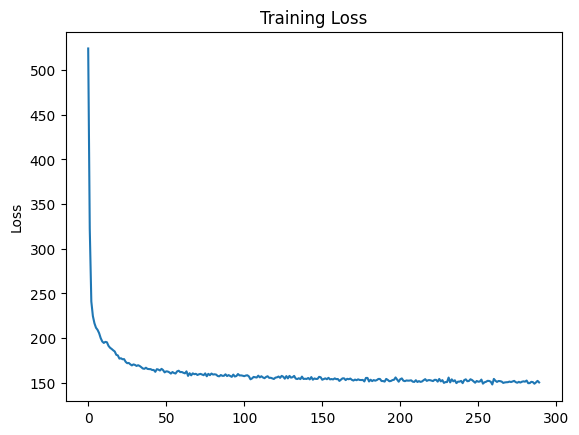

In [ ]:
# plot training loss
plt.plot(training_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.show()

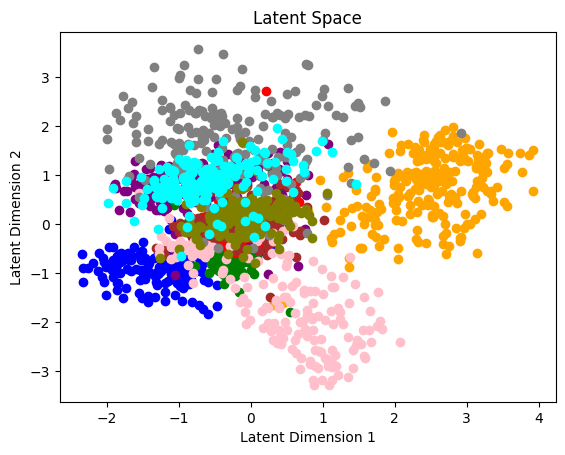

In [ ]:
# plot the latent space (only works when LATENT_DIMS = 2)
if LATENT_DIMS == 2:
    all_labels = np.empty(16 * BATCH_SIZE)
    all_mu = np.empty((16 * BATCH_SIZE, LATENT_DIMS))

    vae.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_dataloader):
            all_labels[batch_idx * 128 : (batch_idx + 1) * 128] = labels.numpy()

            mu, logvar = encoder(images)
            epsilon = torch.randn_like(logvar)
            z = mu + torch.exp(logvar / 2) * epsilon

            all_mu[batch_idx * 128 : (batch_idx + 1) * 128] = z.numpy()

            if batch_idx == 15:
                break

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for label in range(10):
        indices = np.where(all_labels == label)
        plt.scatter(all_mu[indices, 0], all_mu[indices, 1], color=colors[label])

    plt.title('Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

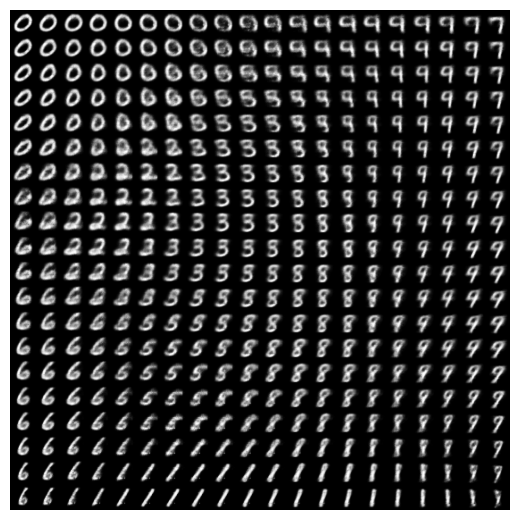

In [ ]:
# latent space traversal (only works when LATENT_DIMS = 2)
if LATENT_DIMS == 2:
    from scipy.stats import norm

    grid = np.linspace(0.05, 0.95, 20)
    points = torch.tensor([[norm.ppf(x), norm.ppf(y)] for x in grid for y in grid], dtype=torch.float32, device=device)

    vae.eval()
    with torch.no_grad():
        images = decoder(points)

    fig, axes = plt.subplots(nrows=20, ncols=20, figsize=(5,5))

    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].squeeze().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_aspect('equal')
        ax.set_adjustable('box')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()

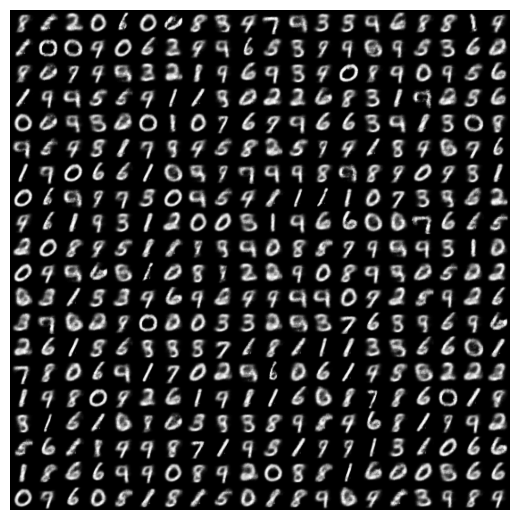

In [ ]:
# generate new images
z = torch.randn((400, LATENT_DIMS))

vae.eval()
with torch.no_grad():
    images = decoder(z)

fig, axes = plt.subplots(nrows=20, ncols=20, figsize=(5,5))

for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx].squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_adjustable('box')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()